# COVID-19 Spread Toy Example
## Initilization Anchored NN Ensemble Sanity Check


In this notebook I want to demonstrate that my tensorflow implementation of the ensemble neural network is actually working and useful. In the spirit of times, I will try to learn the _hypothetical_ spreading of the COVID-19 disease in the _hypothetical_ island of Wakanda through the period of one year.

In [1]:
from simba.infrastructure import MLPEnsemble, InitializationAnchoredNN
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-

First we generate some data using the [SIR model](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html) of covid19: 

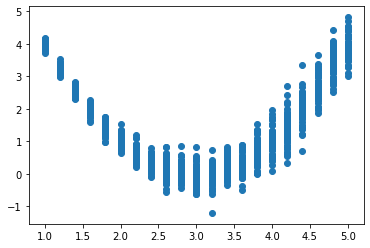

In [2]:
def f(x):
    return x**2-6*x+9
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)
n_samples = 50
noise = 0.1
inputs = np.array([])
targets = np.array([])
time = np.arange(1,5.2,0.2)
for day in time:
    inputs = np.append(inputs, np.full(n_samples, day))
    targets = np.append(targets, data_generator(day, noise, n_samples))
plt.scatter(inputs, targets)
plt.show()

In [3]:
def generate_covid_19_infection_rate_data():
    # https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
    # https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
    population = 15000
    days = 365
    i_0, r_0 = 2, 0
    s_0 = population - i_0 - r_0
    beta, gamma = 0.3, 0.02
    t = np.linspace(0, days, days)

    def deriv(y, t, population, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / population
        dIdt = beta * S * I / population - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    y_0 = s_0, i_0, r_0
    ret = odeint(deriv, y_0, t, args=(population, beta, gamma))
    _, infected_people, _ = ret.transpose()
    return t, infected_people

Say we have only have access to noisy measurements of how many people were sick on a certain day: 

In [4]:
# time, infected_people = generate_covid_19_infection_rate_data()
# n_samples = 2
# noise = 0.001
# inputs = np.array([])
# targets = np.array([])
# for day, sick_people_that_day in zip(time, infected_people):
#     inputs = np.append(inputs, np.full(n_samples, day))
#     targets = np.append(targets, np.random.normal(
#     sick_people_that_day, noise * sick_people_that_day, n_samples))

In [5]:
# Some hyperparameters
def make_model(sess):
    mlp_dict = dict(
        input_dim=1,
        targets_dim=1,
        learning_rate=0.0003,
        n_layers=3,
        hidden_size=12,
        activation=tf.nn.tanh,
        anchor=False,
        init_std_bias=100,
        init_std_weights=3.5,
        data_noise=0.1
    )
    return MLPEnsemble(
        sess=sess,
        ensemble_size=5,
        n_epochs=500,
        batch_size=50,
        **mlp_dict
    )
#     return InitializationAnchoredNN(sess,scope="fdfdf", **mlp_dict)

Run the training loop:

In [6]:
tf.reset_default_graph()

In [19]:
n_particles = 1
x_val = np.tile(time, n_particles)
data_mean = inputs.mean()
data_std = inputs.std()
x = np.squeeze((inputs - data_mean) / (data_std + 1e-8))
x_test = (x_val - data_mean) / (data_std + 1e-8)
batch_num = int(len(inputs) / 50)
with tf.Session() as sess:
    model = make_model(sess)
    sess.run(tf.global_variables_initializer())
#     for epoch in range(500):
#         rand_ind = np.random.permutation(x.shape[0])
#         x_batches = np.array_split(x[rand_ind], batch_num)
#         y_batches = np.array_split(targets[rand_ind], batch_num)
#         avg_loss = 0.0
#         for i in range(batch_num):  
#             x_batch = np.expand_dims(x_batches[i],axis=1)
#             y_batch = np.expand_dims(y_batches[i],axis=1)
#             avg_loss += model.fit(x_batch, y_batch) / batch_num
#         if epoch % 20 == 0:
#             print(avg_loss)
#     print(inputs.shape, targets.shape)
    model.fit(x[:, np.newaxis], targets[:, np.newaxis])
    mus, sigmas, preds = np.squeeze(model.predict(x_test[:, np.newaxis]))

Epoch  0  | Losses = [ 2.9493542 18.08149    3.7447362  3.9302235  4.079547 ]
Epoch  20  | Losses = [1.7743236 2.1593783 1.866502  1.8503566 1.9232265]
Epoch  40  | Losses = [1.7373558 1.9847538 1.7493944 1.7404004 1.7605141]
Epoch  60  | Losses = [1.7220771 1.8719784 1.7189409 1.7134421 1.7336478]
Epoch  80  | Losses = [1.6684517 1.8014603 1.6304814 1.628921  1.7015064]
Epoch  100  | Losses = [0.6748495  1.7560831  0.7127359  0.78923184 1.5746555 ]
Epoch  120  | Losses = [0.36883286 1.7104264  0.41454706 0.36437255 0.69324815]
Epoch  140  | Losses = [0.28098243 1.6400554  0.29023647 0.26410186 0.49778256]
Epoch  160  | Losses = [0.2095863  1.4630979  0.2016977  0.20044638 0.38417244]
Epoch  180  | Losses = [0.17012414 0.8992009  0.1571037  0.16863397 0.29708496]
Epoch  200  | Losses = [0.13789298 0.6211486  0.1355589  0.13811325 0.2356031 ]
Epoch  220  | Losses = [0.12589014 0.48535776 0.12666486 0.12840256 0.1844054 ]
Epoch  240  | Losses = [0.11718581 0.3739288  0.12287502 0.1160298

Reshaping back to (ensemble_size, n_particles, 365days). n_samples will help estimating aleatoric uncertainty and ensemble_size will help estimating epistemic uncertainty.

<ErrorbarContainer object of 3 artists>

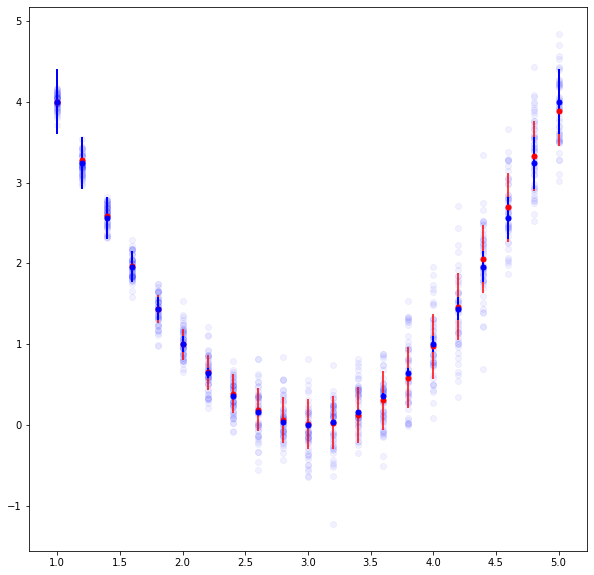

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
mu_pred = mus.mean(axis=0)
sigma_pred = sigmas.mean(axis=0)
ax.errorbar(x_val,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(inputs,targets,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_val,f(x_val),yerr=noise*f(x_val),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')

In [8]:
pred = np.reshape(pred, 
                  (model.ensemble_size, n_particles, time.shape[0]))
# # For more details on decomposition of uncertainties: http://proceedings.mlr.press/v80/depeweg18a/depeweg18a.pdf 
aleatoric_uncertainty = np.mean(np.std(pred, axis=1) ** 2, axis=0)
epistemic_uncertainty = np.std(np.mean(pred, axis=1), axis=0) ** 2

NameError: name 'pred' is not defined

Do some plotting

In [ ]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.subplots()
ax.set_ylim([-100, 15e3])
ax.scatter(inputs, targets, color='#FF764D', alpha=0.6,
           s=5, label='Infectious people a day')
# for mlp in range(model.ensemble_size):
#     ax.plot(time, np.mean(pred[mlp], axis=0), '-', color='#C20093', linewidth=1, label='Predictions')
ax.fill_between(time, np.mean(pred, axis=(0, 1)) - np.sqrt(epistemic_uncertainty),
                np.mean(pred, axis=(0, 1)) + np.sqrt(epistemic_uncertainty),
                color='#FC206C', alpha=0.15, label='Epistemic uncertainty')
ax.errorbar(time, np.mean(pred, axis=(0, 1)), yerr=np.sqrt(aleatoric_uncertainty), linewidth=0.0,
             ecolor='silver', elinewidth=3, capsize=0.0, label='Aleatoric uncertainty', alpha=0.5)
ax.legend(loc='upper right', fontsize='medium')
plt.xlabel("Days")
plt.ylabel("Infectious people")
plt.show()

In [ ]:
mus = np.reshape(mus, 
                  (model.ensemble_size, n_particles, time.shape[0]))
sigmas = np.reshape(sigmas, 
                  (model.ensemble_size, n_particles, time.shape[0]))
# # For more details on decomposition of uncertainties: http://proceedings.mlr.press/v80/depeweg18a/depeweg18a.pdf 
aleatoric_uncertainty = np.mean(sigmas ** 2, axis=(1, 0))
epistemic_uncertainty = np.std(mus, axis=(1, 0)) ** 2

In [ ]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.subplots()
ax.set_ylim([-100, 15e3])
ax.scatter(inputs, targets, color='#FF764D', alpha=0.6,
           s=5, label='Infectious people a day')
ax.fill_between(time, np.mean(mus, axis=(0, 1)) - np.sqrt(epistemic_uncertainty),
                np.mean(mus, axis=(0, 1)) + np.sqrt(epistemic_uncertainty),
                color='#FC206C', alpha=0.15, label='Epistemic uncertainty')
ax.errorbar(time, np.mean(mus, axis=(0, 1)), yerr=np.sqrt(aleatoric_uncertainty), linewidth=0.0,
             ecolor='silver', elinewidth=3, capsize=0.0, label='Aleatoric uncertainty', alpha=0.5)
plt.xlabel("Days")
plt.ylabel("Infectious people")
plt.show()

[[0.30965865]
 [0.30508083]
 [0.3038156 ]
 [0.3137833 ]
 [0.3183481 ]]


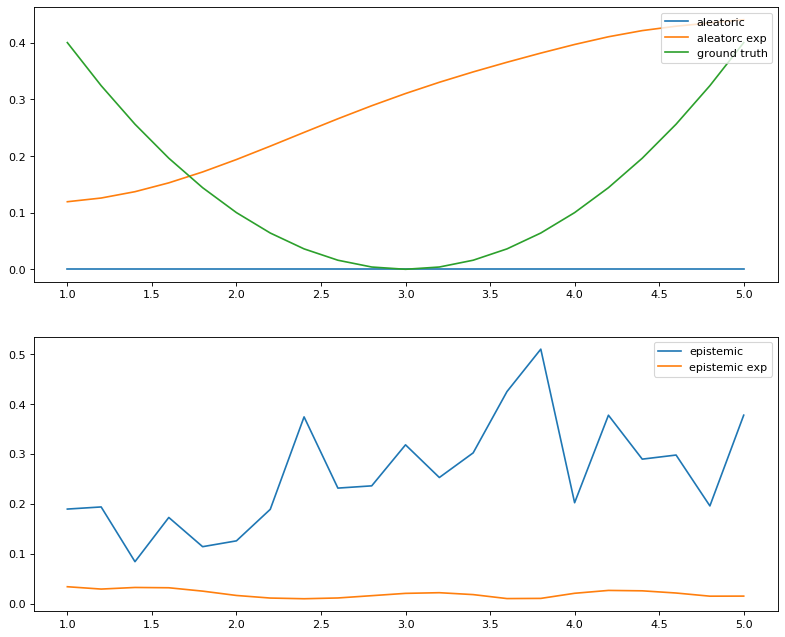

In [49]:
mus = np.reshape(mus, 
                  (model.ensemble_size, n_particles, time.shape[0]))
sigmas = np.reshape(sigmas, 
                  (model.ensemble_size, n_particles, time.shape[0]))
preds = np.reshape(preds, 
                  (model.ensemble_size, n_particles, time.shape[0]))
print(sigmas[:, :, 10])
aleatoric_uncertainty_explicit = np.mean(sigmas, axis=(0, 1))
epistemic_uncertainty_explicit = np.std(mus, axis=(0, 1))
aleatoric_uncertainty = np.mean(np.std(preds, axis=1), axis=0)
epistemic_uncertainty = np.std(np.mean(preds, axis=1), axis=0)
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(211)
ax1.plot(time, aleatoric_uncertainty, label='aleatoric')
ax1.plot(time, aleatoric_uncertainty_explicit, label='aleatorc exp')
ax1.plot(x_val, (f(x_val * noise), label='ground truth')
ax1.legend(loc='upper right', fontsize='medium')
ax2 = fig.add_subplot(212)
ax2.plot(time, epistemic_uncertainty, label='epistemic')
ax2.plot(time, epistemic_uncertainty_explicit, label='epistemic exp')
ax2.legend(loc='upper right', fontsize='medium')
plt.show()